## Importing Libraries and Dataset

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics import ConfusionMatrix, Accuracy
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from timeit import default_timer as timer
import random
import numpy as np
#use gpu if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(42)

Using device: cuda


In [ ]:
# setup training data
train_data = datasets.CIFAR10(
    root='data',
    train=True,
    download=True, # download data if does not exist on disk
    transform=ToTensor(), # turn PIL format of images into Torch tensors
    target_transform=None, 
)

# setup test data
test_data = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


order of tensor = CHW (color channels first)

shape = [color_channels, height, width]

greyscale -> color_channels = 1

rgb -> color_channels = 3

## Exploring Dataset

In [32]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
class_names = train_data.classes
print(f"Class names: {class_names}")

Number of training samples: 50000
Number of test samples: 10000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [33]:
def permute_image(img):
    """Permute image tensor from CHW to HWC format"""
    if img.shape[0] == 1 or img.shape[0] == 3:  # if greyscale image
        img = img.permute(1, 2, 0)  # permute from (C,H,W) to (H,W,C)
    return img

Text(0.5, 1.0, 'frog')

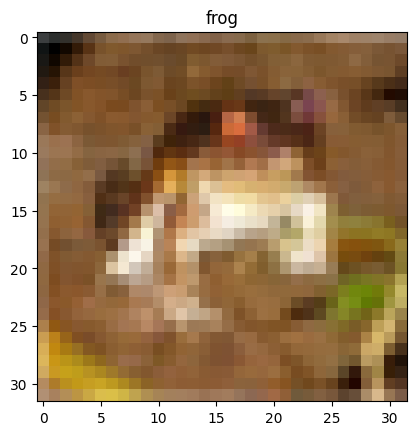

In [34]:
#matplotlib expect image arrays in height x width x channels (HWC) order 
#pytorch tensor in CHW format so must permute dimensions

img=permute_image(train_data[0][0]) #get first image from training data
plt.imshow(img.squeeze()) 
plt.title(class_names[train_data[0][1]]) #get label of first image

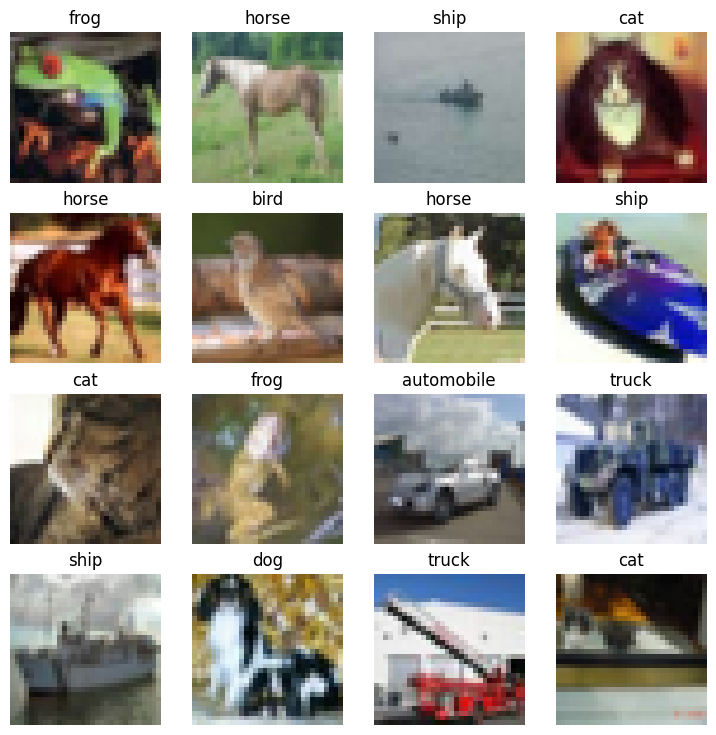

In [35]:
# plot more images
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1, rows*cols + 1):
    # size = [1] creates tensor with 1 element, tensor([random_idx]), .item extracts idx
    random_idx = torch.randint(0, len(train_data), size=[1]).item() 
    img,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    img=permute_image(img)
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

## Prepare DataLoader

In [36]:
# DataLoader helps load data into model for training and inference
# turns Dataset into python iterable of smaller chunks (batches) to make more computationally efficient
# gradient descent perfomed more often per epoch as now once per batch rather than once per epoch

# hyperparameter
BATCH_SIZE = 32

train_dataloader=DataLoader(
    train_data, # train data to turn into batch
    batch_size=BATCH_SIZE,
    shuffle=True #shuffle data every epoch to ensure model does not learn order of data (which is not important for image classification tasks)   
    )

test_dataloader=DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False #dont have to shuffle testing data
)

print(f"Dataloaders: {train_dataloader,test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

# iter(train_dataloader) converts dataloader into iterator to allow to manually step through batches
# next(...) gets next item fm iterator - as first call returns firt batch 
# returns tuple of (features, labels) for batch

train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Shape of train features batch: {train_features_batch.shape}")
print(f"Shape of train labels batch: {train_labels_batch.shape}")
# train_features_batch = batch of 32 images (features)
# train_labels_batch = batch of 32 labels (one for each image in batch)

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001EC15393710>, <torch.utils.data.dataloader.DataLoader object at 0x000001EC295AB250>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32
Shape of train features batch: torch.Size([32, 3, 32, 32])
Shape of train labels batch: torch.Size([32])


## Define training and test steps

In [37]:
def train_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimiser: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device=device
):
    
    train_loss,train_acc=0,0
    model.to(device)
    model.train() #put model in training mode to enable dropout, batch norm etc
    for batch,(X,y) in enumerate(data_loader):
        #send data to device
        X,y=X.to(device),y.to(device)
        #1. forward pass - passes batch of images through model
        y_pred=model(X) #y_pred shape = [32,10] = [samples,classes]

        #2. calculate loss per batch
        loss=loss_fn(y_pred,y) #compares predictions to true labels using CrossEntropyLoss
        train_loss+=loss # accumulatively add up loss per epoch
        train_acc+=accuracy_fn(y_pred.argmax(dim=1),y)

        #3. optimiser zero grad
        optimiser.zero_grad() 
        #clears gradients fm previous batch
        #pytorch accumulates gradients by default - need fresh gradients

        #4. loss backward
        loss.backward()
        #backpropagation - calculates grads for all params - computes how much each weight contributed to loss

        #5. optimiser step
        optimiser.step()
        #updates model weights using calculated grads, uses grad descent to move weights in direction that reduces loss

        #print how many samples processed
        # if batch % 400 ==0:
        #     print(f"Processed {batch*len(X)}/{len(train_dataloader.dataset)} samples")
    
    #average loss per batch per epoch = total train loss divided by length of train dataloader
    train_loss /= len(train_dataloader)
    train_acc /=len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

In [38]:
def test_step(
        data_loader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        loss_fn: torch.nn.Module,
        accuracy_fn,
        device: torch.device=device
):
    
    test_loss,test_acc=0,0
    model.to(device)
    model.eval()
    #turn on inference context manager to disable gradient tracking
    with torch.inference_mode():
        for X,y in data_loader:
            X,y=X.to(device),y.to(device)
            
            #1. forward pass
            test_pred = model(X)
            #no grad computation as in inference_mode

            #2. calculate loss (accumulatively)
            test_loss+=loss_fn(test_pred,y)

            #3. calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
            #test_pred.argmax(dim=1) converts logits to predicted class indices
            #accuracy_fn compares predicted vs true labels
        
        #average loss per batch = total test loss divided by length of test dataloader
        test_loss /= len(data_loader)

        #average accuracy per batch = total accuracy divided by length of test dataloader
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc

In [39]:
def eval_model(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        accuracy_fn,
        device: torch.device=device):
    """
    Returns a dict containing results of model predicting on data_loader
    
    Args:
        model (torch.nn.Module): Pytorch model capable of making predictions on data_loader
        data_loader (torch.utils.data.DataLoader): target dataset to predict on
        loss_fn (torch.nn.Module): loss function of model
        accuracy_fn: accuracy fn to compare models predictions to true labels
        device (str, optional): target device to compute on, defaults to device
    
    Returns:
        (dict): results of model making predictions on data_loader
    """

    loss,acc=0,0
    model.to(device) 
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y=X.to(device),y.to(device)

            # make predictions with model
            y_pred=model(X)

            #accumulate loss and accuracy values per batch
            loss+=loss_fn(y_pred,y)
            #for accuracy need prediction labels (logits -> pred_prob -> pred_labels)
            acc+=accuracy_fn(y_pred.argmax(dim=1),y)
        
        #scale loss and acc to find avg loss/acc per batch
        loss/=len(data_loader)
        acc/= len(data_loader)
    
    return {
        "model_name":model.__class__.__name__,
        "model_loss":loss.item(),
        "model_acc":acc.item()
    }

In [40]:
def print_train_time(
        start: float, 
        end: float, 
        device: torch.device = None):
    """prints difference between start and end time

    Args:
        start (float): start time of computation
        end (float): end time of computation
        device ([type], optional): device that compute is running on, defaults to None

    Returns:
        float: time between start and end in seconds (higher is longer)
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [41]:
def accuracy_fn(pred,true):
    return 100*sum(pred==true)/len(true)

def train_model(model,epochs):
    #accuracy_fn = Accuracy(task='multiclass',num_classes=OUTPUT_SHAPE).to(device)

    train_accs,test_accs,train_losses,test_losses = [],[],[],[]

    loss_fn = nn.CrossEntropyLoss() #equivalent to cost fn or criterion
    optimiser = torch.optim.Adam(
        params=model.parameters(),
        lr=1e-3,
        weight_decay=1e-4) #L2 regularisation to reduce overfitting
    
    train_time_start=timer()
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n-------------------")
        train_loss,train_acc=train_step(
            data_loader=train_dataloader,
            model=model,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn
        )
        test_loss,test_acc=test_step(
            data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn
        )

        train_accs.append(train_acc.item())
        test_accs.append(test_acc.item())
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

    train_time_end=timer()
    total_train_time=print_train_time(
        start=train_time_start,
        end=train_time_end,
        device=device)
    
    model_results=eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device)

    return model_results, total_train_time, train_accs, test_accs, train_losses, test_losses

## Define Different Models

In [42]:
INPUT_SHAPE = 3072 # 3072 pixels (3 channels * 32 * 32)
HIDDEN_UNITS = 512 # num of units/neurons in hidden layer(s)
OUTPUT_SHAPE = len(class_names) # multiclass classification - need output neuron per class 
EPOCHS=7

### baseline

In [43]:
#cretae custom NN class that inherits fm nn.Module
#nn.Module is base class for all neural network modules in PyTorch
class CIFAR10_baseline(nn.Module):
    def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
    ):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # nn.Flatten() layer compresses dimensions of tensor into single vector
            # turned pixel data fm height and width dimensions into one long feature vector
            # nn.Linear() layers want inputs to be in form of feature vectors
            nn.Flatten(), 

            #in_features = num of features in data sample = 1024 pixels (32*32)
            nn.Linear(in_features=input_shape,out_features=hidden_units), 
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self,x): #defines how data flows through network
        #takes input x and passes it through all layers sequentially
        return self.layer_stack(x)

### nonlinear

In [44]:
class CIFAR10_v1(nn.Module):
    def __init__(
            self,
            input_shape:int,
            hidden_units: int,
            output_shape: int
    ):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
            #nn.ReLU() 
        )
    def forward(
            self,
            x: torch.Tensor):
        return self.layer_stack(x)

### Tiny VGG (CNN)

In [45]:
class CIFAR10_conv(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(
            self,
            input_shape:int,
            hidden_units:int,
            output_shape:int):
        super().__init__()
        # first convolutional block
        #input = [batch_size, channels, height, width] = [32, 3, 32, 32]
        #conv2d = [batch_size, out_channels, height, width] = [32, hidden_units, 32, 32]
        #maxpool2d = [batch_size, out_channels, height/2, width/2] = [32, hidden_units, 16, 16]
        self.block_1=nn.Sequential(
            #conv2d as 2D data (images) has 2 spatial dimensions (height and width)
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2)
        )
        #second convolutional block
        #input = [batch_size, out_channels, height/2, width/2] = [32, hidden_units, 16, 16]
        #conv2d = [batch_size, out_channels, height/2, width/2] = [32, hidden_units, 16, 16]
        #maxpool2d = [batch_size, out_channels, height/4, width/4] = [32, hidden_units, 8, 8]
        self.block_2=nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,1,1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        #final classifier layer
        #input = [batch_size, out_channels, height/4, width/4] = [32, hidden_units, 8, 8]
        #flatten = [batch_size, out_channels*height/4*width/4] = [32, hidden_units*8*8]
        #linear = [batch_size, output_shape] = [32, 10]
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*8*8, # 8x8 is output size after 2 max pooling layers
                out_features=output_shape
            )
        )
    def forward(
            self,
            x:torch.Tensor):
        x=self.block_1(x)
        # print(f"Shape after block 1: {x.shape}")
        x=self.block_2(x)
        # print(f"Shape after block 2: {x.shape}")    
        x=self.classifier(x)
        # print(f"Shape after classifier: {x.shape}")
        return x

## Train or Load in Models

In [46]:
import os

# Create models directory if it doesn't exist
os.makedirs("params", exist_ok=True)

def save_model(model, model_name, results=None):
    """Save model state dict and optionally results"""
    # Save model state dict
    model_path = f"params/{model_name}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    # Save results if provided
    if results:
        results_path = f"params/{model_name}_results.pth"
        torch.save(results, results_path)
        print(f"Results saved to {results_path}")

def load_model(model_class, model_name, input_shape, hidden_units, output_shape):
    """Load model state dict and return model instance"""
    model_path = f"params/{model_name}.pth"
    
    if os.path.exists(model_path):
        # Create model instance
        if model_name == "baseline":
            model = model_class(input_shape=input_shape, hidden_units=hidden_units, output_shape=output_shape)
        elif model_name == "nonlinear":
            model = model_class(input_shape=input_shape, hidden_units=hidden_units, output_shape=output_shape)
        elif model_name == "cnn":
            model = model_class(input_shape=3, hidden_units=hidden_units, output_shape=output_shape)
        
        # Load state dict
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        print(f"Model loaded from {model_path}")
        return model
    else:
        print(f"No saved model found at {model_path}")
        return None

def load_results(model_name):
    """Load saved results"""
    results_path = f"params/{model_name}_results.pth"
    if os.path.exists(results_path):
        results = torch.load(results_path, map_location=device, weights_only=False)
        print(f"Results loaded from {results_path}")
        return results
    else:
        print(f"No saved results found at {results_path}")
        return None


In [47]:
# Baseline Model - Load or Train
model_baseline = load_model(CIFAR10_baseline, "baseline", 3072, HIDDEN_UNITS, OUTPUT_SHAPE)
baseline_data = load_results("baseline")

if model_baseline is None or baseline_data is None:
    print("Training baseline model...")
    model_baseline = CIFAR10_baseline(
        input_shape=3072,
        hidden_units=HIDDEN_UNITS,
        output_shape=OUTPUT_SHAPE
    )
    
    (model_baseline_results, 
     model_baseline_time, 
     model_baseline_train_accs, 
     model_baseline_test_accs,
     model_baseline_train_losses, 
     model_baseline_test_losses) = train_model(model_baseline, EPOCHS)
    
    # Save the trained model and results
    save_model(model_baseline, "baseline", {
        'results': model_baseline_results,
        'time': model_baseline_time,
        'train_accs': model_baseline_train_accs,
        'test_accs': model_baseline_test_accs,
        'train_losses': model_baseline_train_losses,
        'test_losses': model_baseline_test_losses
    })
else:
    print("Using pre-trained baseline model...")
    model_baseline_results = baseline_data['results']
    model_baseline_time = baseline_data['time']
    model_baseline_train_accs = baseline_data['train_accs']
    model_baseline_test_accs = baseline_data['test_accs']
    model_baseline_train_losses = baseline_data['train_losses']
    model_baseline_test_losses = baseline_data['test_losses']


Model loaded from params/baseline.pth
Results loaded from params/baseline_results.pth
Using pre-trained baseline model...


In [48]:
# Nonlinear Model - Load or Train
model_1 = load_model(CIFAR10_v1, "nonlinear", INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE)
nonlinear_data = load_results("nonlinear")

if model_1 is None or nonlinear_data is None:
    print("Training nonlinear model...")
    model_1 = CIFAR10_v1(
        input_shape=INPUT_SHAPE,
        hidden_units=HIDDEN_UNITS,
        output_shape=OUTPUT_SHAPE
    )
    
    (model_1_results, 
     model_1_time, 
     model_1_train_accs, 
     model_1_test_accs,
     model_1_train_losses, 
     model_1_test_losses) = train_model(model_1, EPOCHS)
    
    # Save the trained model and results
    save_model(model_1, "nonlinear", {
        'results': model_1_results,
        'time': model_1_time,
        'train_accs': model_1_train_accs,
        'test_accs': model_1_test_accs,
        'train_losses': model_1_train_losses,
        'test_losses': model_1_test_losses
    })
else:
    print("Using pre-trained nonlinear model...")
    model_1_results = nonlinear_data['results']
    model_1_time = nonlinear_data['time']
    model_1_train_accs = nonlinear_data['train_accs']
    model_1_test_accs = nonlinear_data['test_accs']
    model_1_train_losses = nonlinear_data['train_losses']
    model_1_test_losses = nonlinear_data['test_losses']


Model loaded from params/nonlinear.pth
Results loaded from params/nonlinear_results.pth
Using pre-trained nonlinear model...


In [49]:
# CNN Model - Load or Train
model_conv = load_model(CIFAR10_conv, "cnn", 3, HIDDEN_UNITS, OUTPUT_SHAPE)
cnn_data = load_results("cnn")

if model_conv is None or cnn_data is None:
    print("Training CNN model...")
    model_conv = CIFAR10_conv(
        input_shape=3,
        hidden_units=HIDDEN_UNITS,
        output_shape=OUTPUT_SHAPE
    )
    
    (model_conv_results, 
     model_conv_time, 
     model_conv_train_accs, 
     model_conv_test_accs,
     model_conv_train_losses, 
     model_conv_test_losses) = train_model(model_conv, EPOCHS)
    
    # Save the trained model and results
    save_model(model_conv, "cnn", {
        'results': model_conv_results,
        'time': model_conv_time,
        'train_accs': model_conv_train_accs,
        'test_accs': model_conv_test_accs,
        'train_losses': model_conv_train_losses,
        'test_losses': model_conv_test_losses
    })
else:
    print("Using pre-trained CNN model...")
    model_conv_results = cnn_data['results']
    model_conv_time = cnn_data['time']
    model_conv_train_accs = cnn_data['train_accs']
    model_conv_test_accs = cnn_data['test_accs']
    model_conv_train_losses = cnn_data['train_losses']
    model_conv_test_losses = cnn_data['test_losses']

Model loaded from params/cnn.pth
Results loaded from params/cnn_results.pth
Using pre-trained CNN model...


## Visualise

In [50]:
def make_predictions(
        model:torch.nn.Module,
        data:list,
        device:torch.device=device
):
    pred_probs=[]
    model.to(device) #send model to device
    model.eval()
    with torch.inference_mode(): #disable gradient computation
        #process each image individually, unlike batch processing during training
        for sample in data:
            #prepare sample
            #input: [3, 32, 32] (CIFAR10 image)
            #output: [1, 3, 32, 32] (add batch dimension)
            #models expect batch format [batch_size, channels, height, width] even for single predictions
            sample=torch.unsqueeze(sample,dim=0).to(device) #add an extra dimension to sample

            #forward pass (model outputs raw logit)
            #input: [1, 3, 32, 32] (batch of 1 image)
            #output: [1, 10] (logits for each class) - logits are raw unnormalised scores, can be <0 or >1
            pred_logit=model(sample)

            #get prediction probability (logit -> pred_prob)
            #input: [1, 10] (logits for each class)
            #output: [10] (predicted probabilities for each class)
            pred_prob=torch.softmax(pred_logit.squeeze(),dim=0)
            #perform softmax on logits dimension not batch dimension
            #in this case have batch size of 1 so can perform on dim=0
            #squeeze removes extra dimension added by unsqueeze, [1, 10] -> [10]

            #get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
        
        #stack pred_probs to turn list into tensor
        return torch.stack(pred_probs)

In [51]:
def visualise_pred(
        model:torch.nn.Module,
):
    test_samples=[]
    test_labels=[]
    for sample,label in random.sample(list(test_data),k=9): #sample 9 random samples from test data
        test_samples.append(sample)
        test_labels.append(label)
    
    pred_probs=make_predictions(
        model=model,
        data=test_samples)
    #turn prediction probabilities into prediction labels by taking argmax
    pred_classes=pred_probs.argmax(dim=1)
    
    #plot predictions
    fig = plt.figure(figsize=(9,9))
    fig.suptitle(f"{model.__class__.__name__} - Predictions", fontsize=16, y=0.98)
    nrows,ncols=3,3
    for i,sample in enumerate(test_samples):
        #create subplot for each sample
        plt.subplot(nrows,ncols,i+1)

        #plot target image
        sample=permute_image(sample) #permute image to HWC format for plotting
        plt.imshow(sample.squeeze())

        #find prediction label (in text form)
        pred_label=class_names[pred_classes[i]]

        #get truth label (in text form)
        truth_label=class_names[test_labels[i]]

        title_text=f"Pred: {pred_label} | Truth: {truth_label}"

        #check for equality and change title colour accordingly
        if pred_label==truth_label:
            plt.title(title_text,fontsize=10,c='g')
        else:
            plt.title(title_text,fontsize=10,c='r')
        plt.axis(False)
    
    plt.tight_layout()
    plt.show()

In [52]:
def plot_conf_mat(
        model:torch.nn.Module,
):
    
    #make predictions with trained model
    y_preds=[]
    model.to(device) #send model to device
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(test_dataloader,desc='Making predictions'):
            X,y=X.to(device),y.to(device)
            #forward pass
            y_logit=model(X)
            #turn preds from logits -> prediction probabilitues -> prediction labels
            y_pred=torch.softmax(y_logit,dim=1).argmax(dim=1)
            #perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
            
            #put predictions on cpu for evaluation
            y_preds.append(y_pred.cpu())
        
    #concatenate list of predictions into tensor
    y_pred_tensor=torch.cat(y_preds)

    #setup confusion matrix instance and compare predictions to targets
    confmat=ConfusionMatrix(
        num_classes=len(class_names),
        task='multiclass'
    )
    confmat_tensor=confmat(preds=y_pred_tensor, target=torch.tensor(test_data.targets))

    #plot confusion matrix
    fig,ax=plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), #matplotlib expects numpy array, not torch tensor
        class_names=class_names, #turns row and col labels into class names
        figsize=(10,10)
    )
    plt.suptitle(f"{model.__class__.__name__} - Confusion Matrix", fontsize=16)
    plt.show()

In [53]:
def plot_acc_losses(
        model_name: str,
        train_accs: list,
        test_accs: list,
        train_losses: list,
        test_losses: list,
        epochs: int = 7
):
        f,(ax1,ax2)=plt.subplots(1,2)
        f.set_size_inches(15,5)
        ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
        ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
        ax1.set_title(f"{model_name} Accuracies")
        ax1.legend()
        ax1.set_ylabel("Accuracies (%)")
        ax1.set_xlabel("Epochs")

        ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
        ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
        ax2.set_title(f"{model_name} Losses")
        ax2.legend()
        ax2.set_ylabel("Losses")
        ax2.set_xlabel("Epochs")
    

## Compare Models

In [54]:
compare_results=pd.DataFrame(
    [model_baseline_results, model_1_results, model_conv_results])
# Add training times to results comparison
compare_results["training_time"] = [model_baseline_time,
                                    model_1_time,
                                    model_conv_time]
compare_results

,model_name,model_loss,model_acc,training_time
0,CIFAR10_baseline,1.792852,37.100639,72.225854
1,CIFAR10_v1,1.533002,44.888180,71.544043
2,CIFAR10_conv,0.824977,71.715256,1347.727292


Text(0, 0.5, 'model')

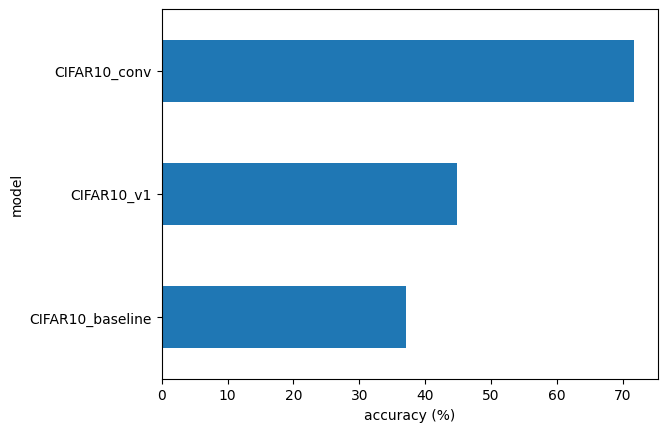

In [55]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

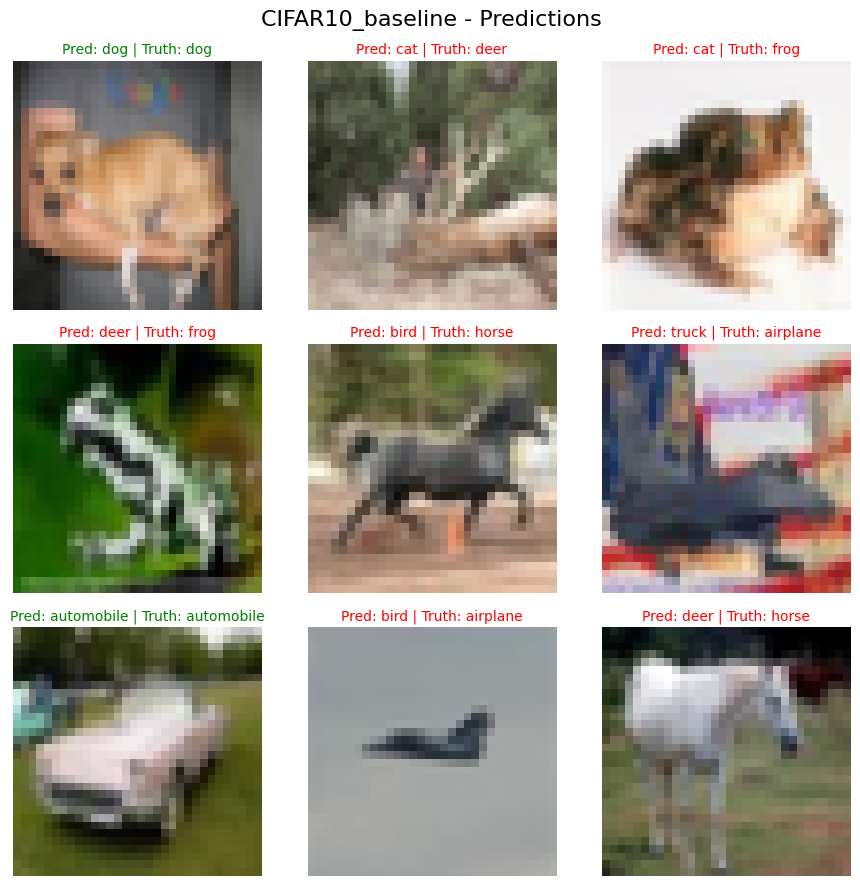

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 211.92it/s]


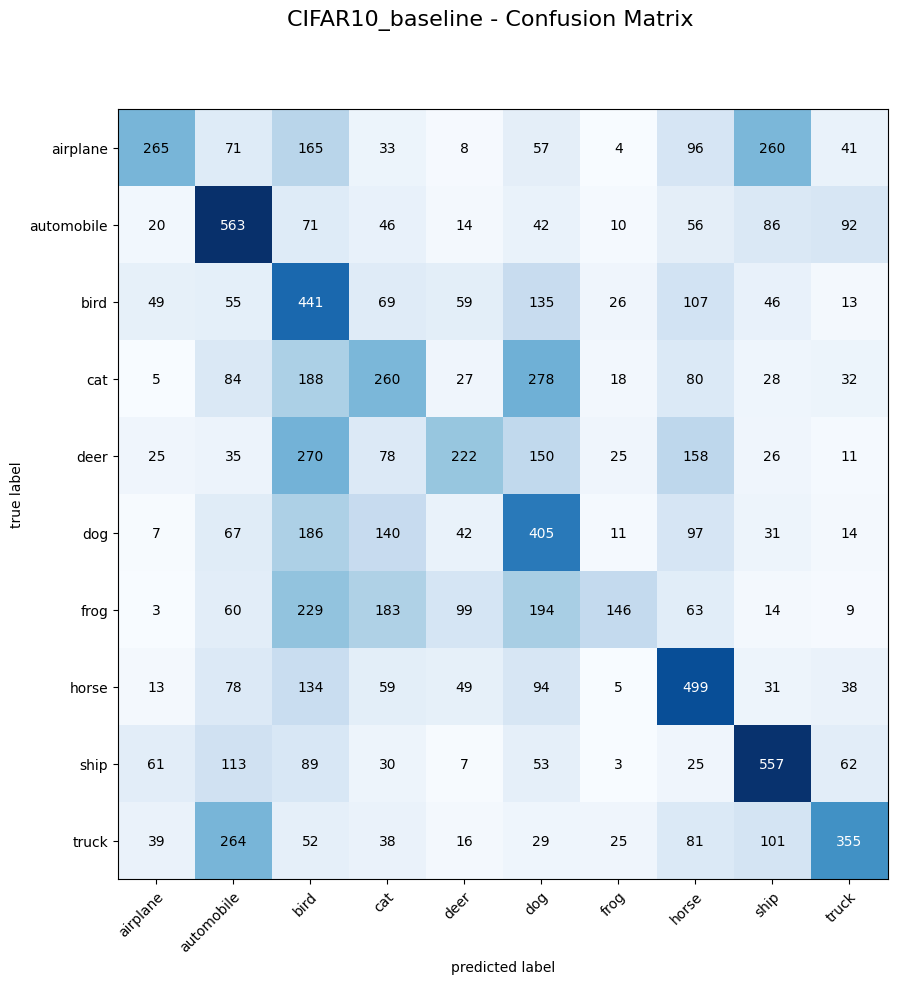

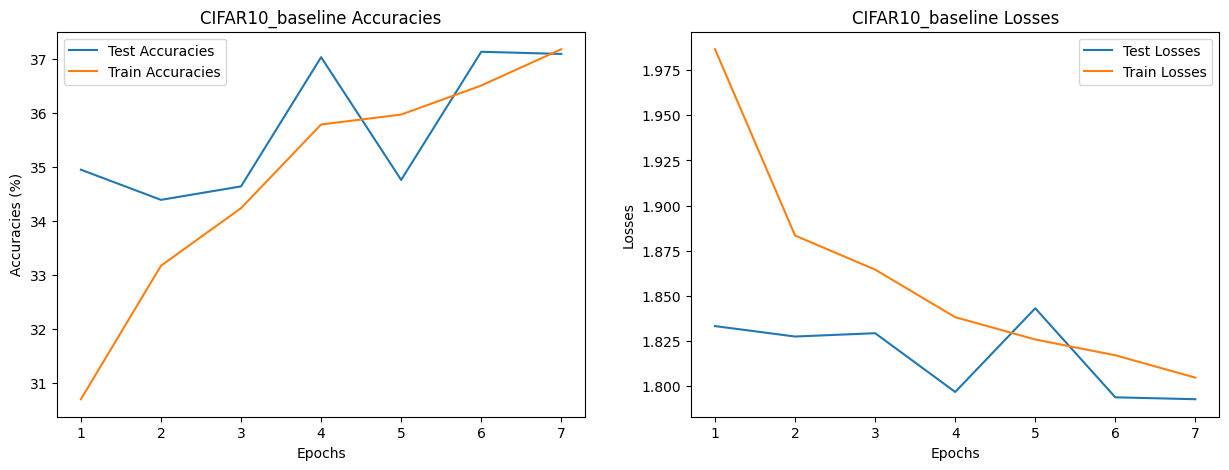

In [56]:
# baseline
visualise_pred(model=model_baseline)
plot_conf_mat(model=model_baseline)
plot_acc_losses(
    model_name=model_baseline.__class__.__name__,
    train_accs=model_baseline_train_accs,
    test_accs=model_baseline_test_accs,
    train_losses=model_baseline_train_losses,
    test_losses=model_baseline_test_losses,
    epochs=EPOCHS
)

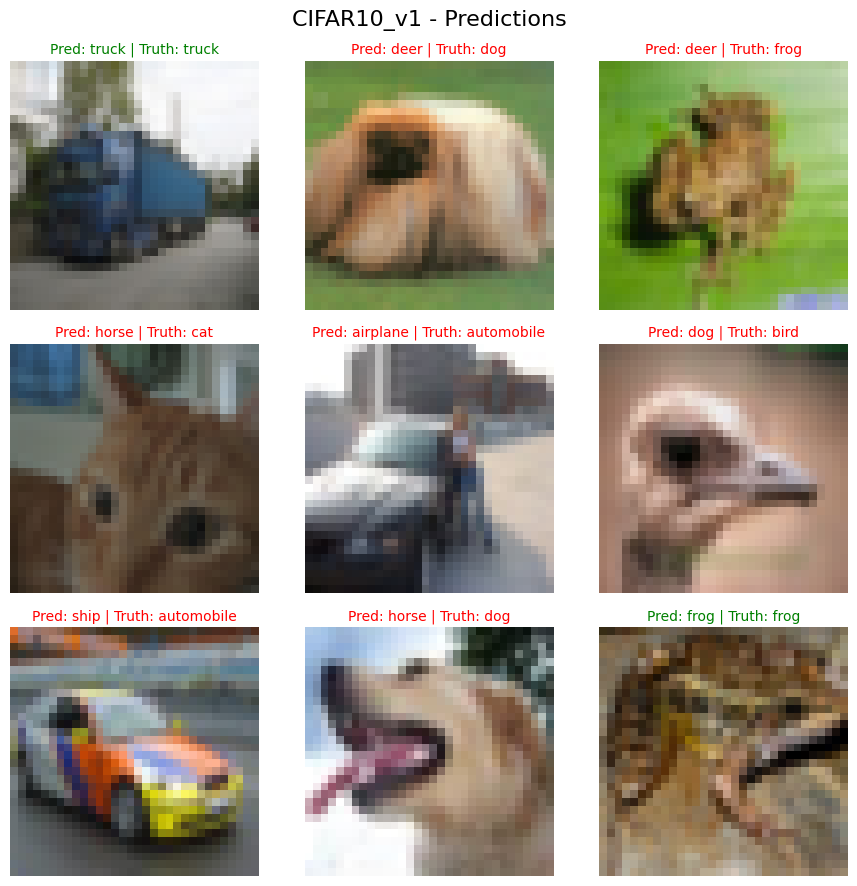

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 196.97it/s]


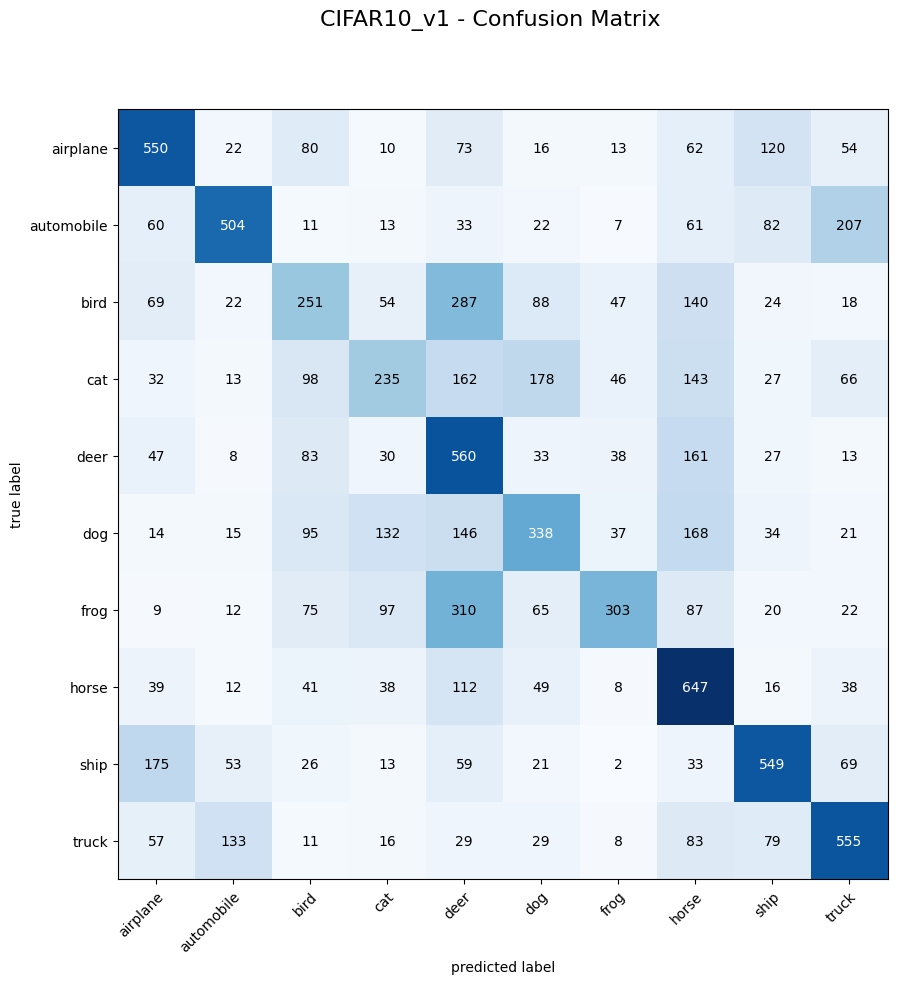

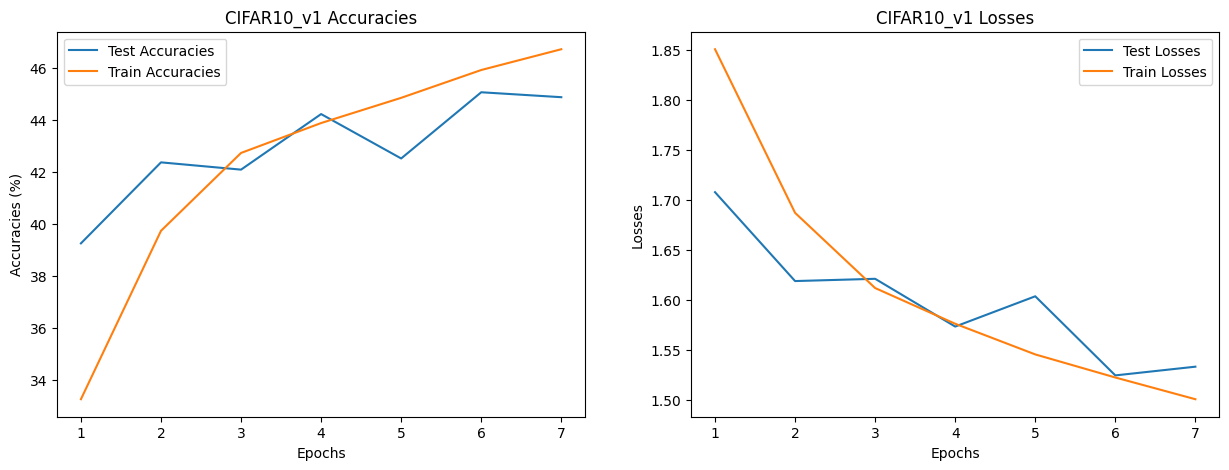

In [57]:
# nonlinear
visualise_pred(model=model_1)
plot_conf_mat(model=model_1)
plot_acc_losses(
    model_name=model_1.__class__.__name__,
    train_accs=model_1_train_accs,
    test_accs=model_1_test_accs,
    train_losses=model_1_train_losses,
    test_losses=model_1_test_losses,
    epochs=EPOCHS
)

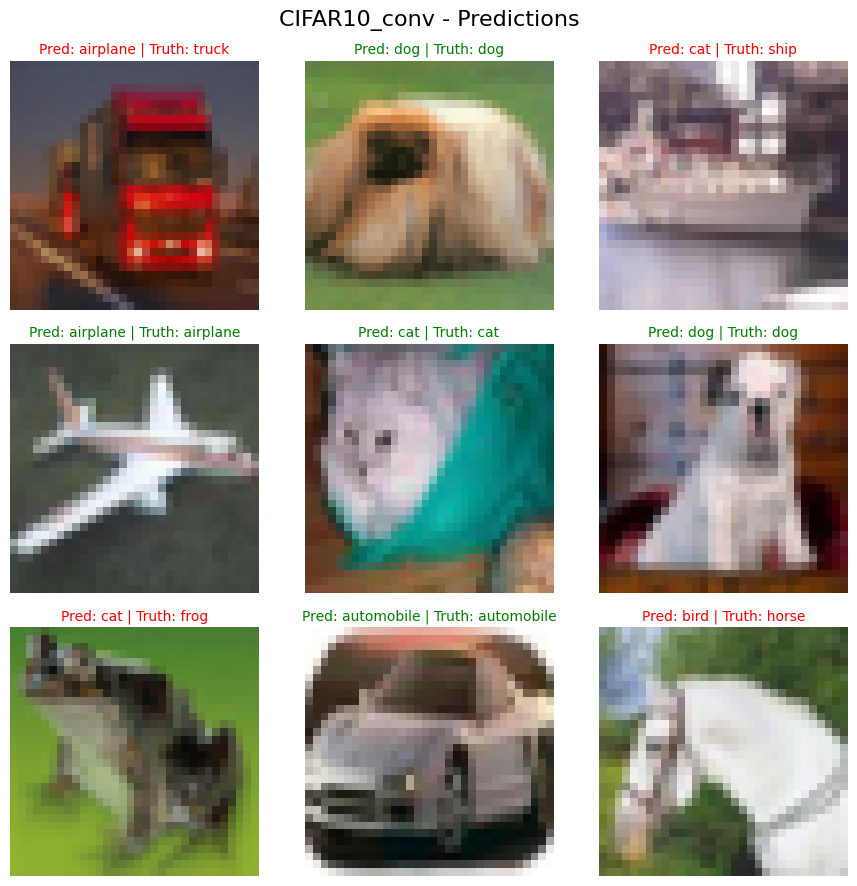

Making predictions: 100%|██████████| 313/313 [00:12<00:00, 24.99it/s]


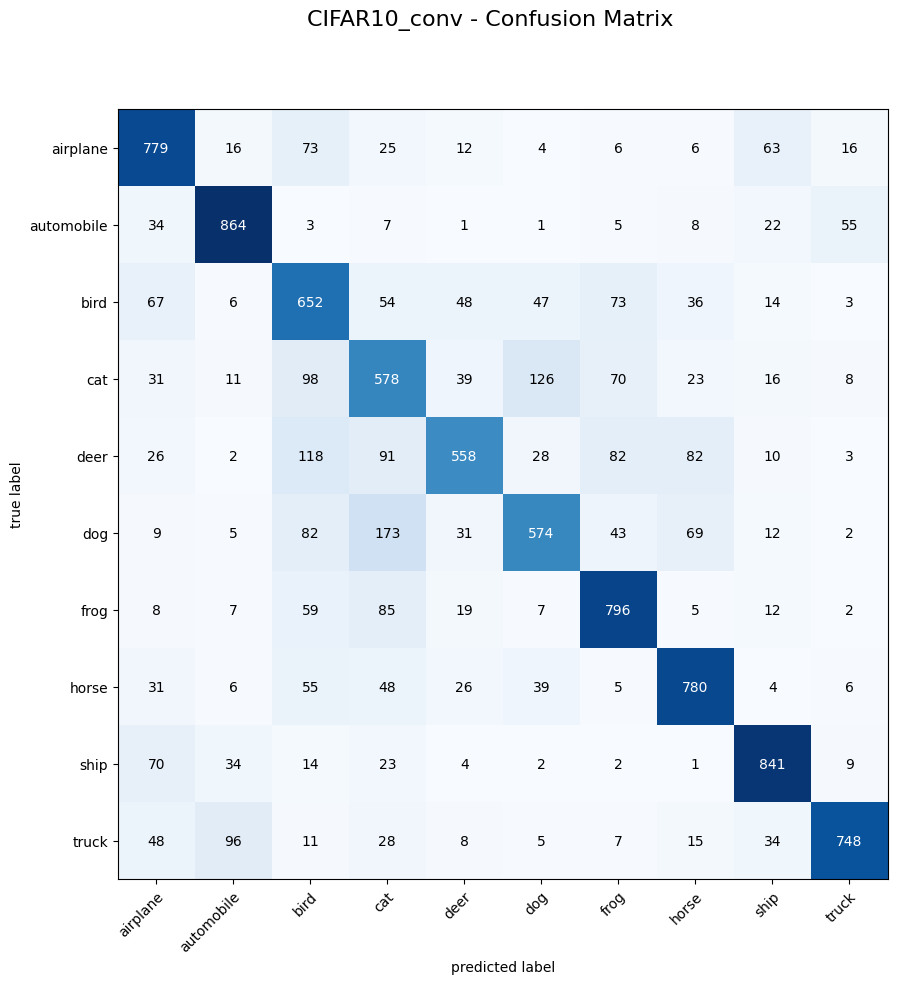

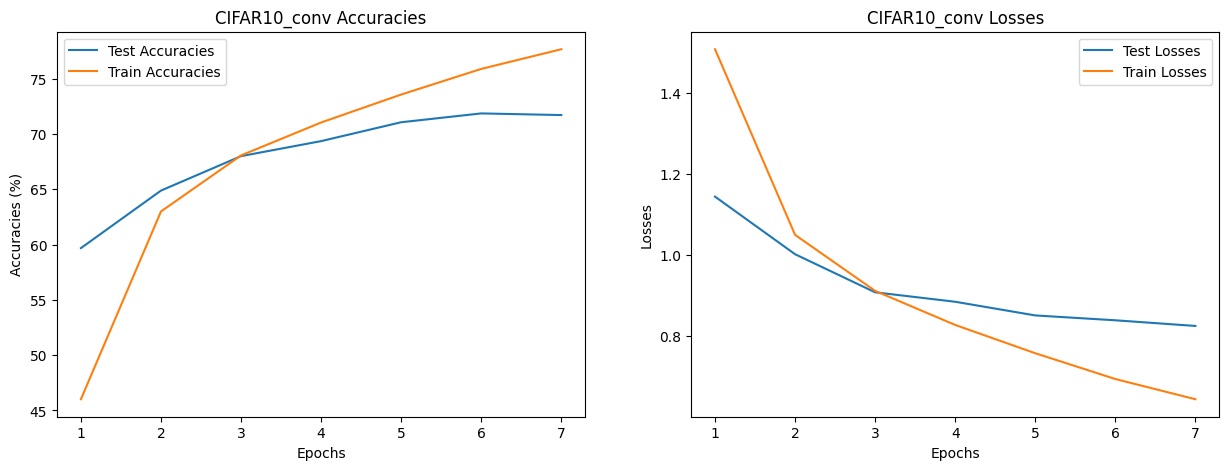

In [58]:
# cnn
visualise_pred(model=model_conv)
plot_conf_mat(model=model_conv)
plot_acc_losses(
    model_name=model_conv.__class__.__name__,
    train_accs=model_conv_train_accs,
    test_accs=model_conv_test_accs,
    train_losses=model_conv_train_losses,
    test_losses=model_conv_test_losses,
    epochs=EPOCHS
)